<a href="https://colab.research.google.com/github/MinsooKwak/Kaggle_note/blob/main/Detection/Face_Detection/Face_Detection_Detectron2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

dataset : https://www.kaggle.com/datasets/dataturks/face-detection-in-images

reference : https://www.kaggle.com/code/dhiiyaur/detectron-2-face-detection

detectron2API : https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5

In [1]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install pyyaml
# !python -m pip install pyyaml==5.1

- yaml 사용법 : https://rfriend.tistory.com/540

In [3]:
# coco api
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-79h_4qkn
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-79h_4qkn
  Resolved https://github.com/cocodataset/cocoapi.git to commit 8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9
  Preparing metadata (setup.py) ... done
  Created wheel for pycocotools: filename=pycocotools-2.0-cp310-cp310-linux_x86_64.whl size=332086 sha256=388a240718203097aedd97904b544c697078ffe1869129cfbf69f759a7d6b264
  Stored in directory: /tmp/pip-ephem-wheel-cache-225xox7t/wheels/39/61/b4/480fbddb4d3d6bc34083e7397bc6f5d1381f79acc68e9f3511
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.6
    Uninstalling pycocotools-2.0.6:
      Successfully uninstalled pycocotools-2.0.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the f

- JSON 파일 -> 이미지에 속한 모든 annotation 정보를 담고 있음.
- 각 정보들을 불러오는 작업을 수행하기 위해 별도 코드 작성 없이 API 통해 불러옴 (Pycocotools)

In [4]:
import torch
import torchvision

Detectron2 install

In [ ]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
#!git clone https://github.com/facebookresearch/detectron2.git
#!pip install -e detectron2

In [6]:
# Detectron2 setup
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.data import datasets, DatasetCatalog, MetadataCatalog, build_detection_test_loader, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.structures import BoxMode

In [11]:
!pip3 install tdqm

In [13]:
from tqdm.notebook import tqdm
import random
import itertools
import ntpath # 경로에서 파일 이름 가져오기 위해

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import PIL.Image as Image
import cv2
import urllib
import os

- ntpath : https://www.delftstack.com/ko/howto/python/get-filename-from-path-in-python/

In [14]:
ls

detectron2/  drive/  sample_data/


In [15]:
# faces 디렉토리 생성
os.makedirs('/content/drive/MyDrive/DataSet/faces', exist_ok=True)

In [16]:
faces_df = pd.read_json('/content/drive/MyDrive/DataSet/face_detection.json', lines=True) # read json object per line

In [17]:
faces_df.head()

,content,annotation,extras
0,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['Face'], 'notes': '', 'points': [{...",NaN
1,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['Face'], 'notes': '', 'points': [{...",NaN
2,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['Face'], 'notes': '', 'points': [{...",NaN
3,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['Face'], 'notes': '', 'points': [{...",NaN
4,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['Face'], 'notes': '', 'points': [{...",NaN


In [19]:
print(f'{faces_df.shape[0]}개의 데이터 존재')

409개의 데이터 존재


In [22]:
faces_df['annotation'][0]

[{'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.08615384615384601, 'y': 0.306306306306306},
   {'x': 0.17230769230769202, 'y': 0.45345345345345306}],
  'imageWidth': 650,
  'imageHeight': 333},
 {'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.583076923076923, 'y': 0.291291291291291},
   {'x': 0.6584615384615381, 'y': 0.468468468468468}],
  'imageWidth': 650,
  'imageHeight': 333}]

In [24]:
faces_df['content'][0]

'http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb064277d86016431e33e4e003d/8186c3d1-e9d4-4550-8ec1-a062a7628787___0-26.jpg.jpeg'

In [ ]:
dataset = []

for index, row in tqdm(faces_df.iterrows(), total=faces_df.shape[0]):

  img = urllib.request.urlopen(row['content'])
  img = Image.open(img)
  img = img.convert('RGB')                  # RGB로 변환
  # img = img.convert('L')                  # GrayScale로 변환

  image_name = f'face_{index}.jpeg'         # labeling image
  img.save(f'faces/{image_name}', "JPEG")   # save to dir

  annotations = row['annotation']
  for i in annotations:

    width = i['imageWidth']
    height = i['imageHeight']
    points = i['points']

    data={}

    data['file_name'] = image_name
    data['width'] = width
    data['height'] = height

    data['x_min'] = int(round(points[0]['x'] * width))
    data['y_min'] = int(round(points[0]['y'] * height))
    data['x_max'] = int(round(points[1]['x'] * width))
    data['y_max'] = int(round(points[1]['y'] * height))

    data['class_name'] = 'face' # 클래스명이 있으면 해당 내용 반영

    dataset.append(data)

403 error : 현재 access denied되어 이미지 다운이 어려운 상황

-> 데이터셋이 형성되었다 가정하고 진행

In [26]:
df = pd.DataFrame(dataset)
df

""


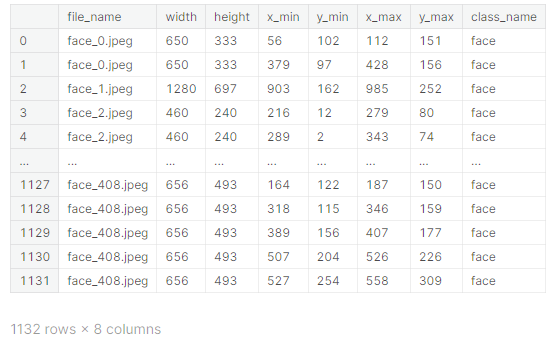

- 이런 데이터셋이 형성됨

In [ ]:
# print(df.file_name.unique().shape[0], df.shape[0])
# 409개의 unque한 file_name , 실제 생성된 데이터셋은 1132개

In [ ]:
df.to_csv('annotations.csv', header=True, index=None)

In [ ]:
DATA_DIR = '/content/drive/MyDrive/DataSet/faces'

In [ ]:
def show_image(image_id):

  bbox = df[df['filename']==image_id] # image_id와 filename 같으면 bbox

  img_path = os.path.join(DATA_DIR, image_id)
  image = cv2.imread(img_path, cv2.IMREAD_COLOR)  # COLOR로 읽어들임. 투명한 부분은 무시 (Default)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
  image /= 255.0
  image2 = image

  for idx, row in bbox.iterrows():

    cv2.rectangle(image, (row.x_min, row.y_min), (row.x_max, row.y_max), color=(255,255,255), thickness=2)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(image, row.class_name, (row.x_min, (row.y_min -10)), font, 1, (255,255,255), 2)

    plt.figure(figsize=(20,20))
    plt.imshow(image)
    plt.axis('off')

In [ ]:
show_image(df.file_name.unique()[40])

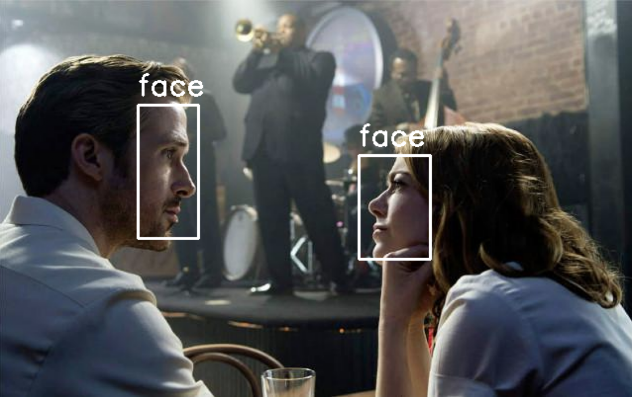

- 이러한 이미지가 나온다함

In [ ]:
unique_files = df.file_name.unique()

train_files = set(np.random.choice(unique_files, int(len(unique_files)*0.95), replace=False))
train_df = df[df.file_name.isin(train_files)]
test_df = df[~df.file_name.isin(train_files)]

train_files

In [ ]:
def create_dataset_dicts(df, classes):

  dataset_dicts = []

  for image_id, img_name in enumerate(df.file_name.unique()):

    record = {}
    image_df = df[df.file_name == img_name]
    file_path = f'{DATA_DIR}/{img_name}'

    record['file_name'] = file_path
    record['image_id'] = image_id
    record['height'] = int(image_df.iloc[0].height)
    record['width'] = int(image_df.iloc[0].width)

    objs = []

    for _, row in image_df.iterrows():

      xmin = int(row.x_min)
      ymin = int(row.y_min)
      xmax = int(row.x_max)
      ymax = int(row.y_max)

      poly = [
          (xmin, ymin), (xmax, ymin)
          (xmax, ymax), (xmin, ymax)
      ]

      poly = list(itertools.chain.from_iterable(poly))

      obj = {
          "bbox": [xmin, ymin, xmax, ymax],
          "bbox_mode": BoxMode.XYXY_ABS,  # bbox 포맷 / XYXY_ABS, XYWH_ABS가 지원됨
          "segmentation": [poly],
          "category_id": classes.index(row.class_name),
          "iscrowd": 0
      }

      objs.append(obj)

    record['annotations'] = objs
    dataset_dicts.append(record)

  return dataset_dicts

In [ ]:
from pandas.core.dtypes.common import classes
def register_dataset(df, dataset_label = 'faces_train', train=True):
  # Register dataset - if dataset is registered, give it a new name

  try :
    DatasetCatalog.register(dataset_label, lambda d=df: create_dataset_dicts(df, classes))
    MetadataCatalog.get(dataset_label).thing_classes = classes

  except:
    # Add random int to dataset name to not run into 'Already registered' error
    n = random.randint(1,1000)
    dataset_label = dataset_label + str(n)
    DatasetCatalog.register(dataset_label, lambda d=df: create_dataset_dicts(df, classes))

  if train == True:
    return MetadataCatalog.get(dataset_label), dataset_label

  else:
    return dataset_label

In [ ]:
# register train dataset
metadata, train_dataset = register_dataset(train_df)

# register validation dataset
test_dataset = register_dataset(test_df, dataset_label='image_test', train=False)

In [ ]:
metadata

image.png
- 예시 output

- detectron2 > configs 아래 COCO-Detection 부분에 yaml 있음

In [ ]:
MODEL_USE = 'retinanet'

if MODEL_USE == 'faster_rcnn':
  MODEL_PATH = 'COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml'
  WEIGHT_PATH = 'COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml'

elif MODEL_USE =='retinanet':
  MODEL_PATH = 'COCO-Detection/retinanet_R_101_FPN_3x.yaml'
  WEIGHT_PATH = 'COCO-Detection/retinanet_R_101_FPN_3x.yaml'

In [ ]:
def cfg_setup():

  cfg = get_cfg()
  cfg.merge_from_file(model_zoo.get_config_file(MODEL_PATH))
  cfg.MODEL_WEIGHTS = model_zoo.get_checkpoint_url(WEIGHT_PATH)
  cfg.MODEL.RETINANET.NUM_CLASSES = 1
  cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512

  cfg.DATASETS.TRAIN = (train_dataset,)
  cfg.DATASETS.TEST = (test_dataset,)
  cfg.DATALOADER.NUM_WORKERS = 4

  cfg.SOLVER.IMS_PER_BATCH =4
  cfg.SOLVER.BASE_LR = 0.001
  cfg.SOLVER.WARMUP_ITERS = 1000
  cfg.SOLVER.STEPS = (1000, 1500)
  cfg.SOLVER.GAMMA =0.05

  cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
  cfg.MODEL.ROL_HEADS.NUM_CLASSES = len(classes)
  cfg.TEST.EVAL_PERIOD = 500

  os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

  return cfg

- 하이퍼파라미터 SOLVER 함수 통해 재정의 : https://danny0628.tistory.com/64

In [ ]:
cfg = cfg_setup()

In [ ]:
trainer = DefaultTrainer(cfg)
trainer = resume_or_load(resume=Fasle)
trainer.train()

In [ ]:
evaluator = COCOEvaluator(test_dataset, cfg, False, output_dir ='./output/')
val_loader = build_detection_test_loader(cfg, test_dataset)
inference_on_dataset(trainer.model, val_loader, evaluator)

In [ ]:
def cfg_test():
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file(MODEL_PATH))
    cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, 'model_final.pth')
    cfg.DATASETS.TEST = (test_dataset,)
    cfg.MODEL.RETINANET.NUM_CLASSES = 1
    cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.45

    return cfg

cfg = cfg_test()
predict = DefaultPredictor(cfg)

In [ ]:
color = (255, 255, 0)

def visual_predict(image, color):
  img = cv2.imread('{}/{}'.format(DATA_DIR, image))
  output = predict(image)

  v = Visualizer(img[:,:, ::-1], metadata=metadata, scale=0.5)
  v = v.draw_instance_predictions(output['instances'].to('cpu'))
  plt.figure(figsize=(14,10))
  plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
  plt.show()

In [ ]:
test_df.file_name.unique()[0]

In [ ]:
visual_predict(test_df.file_name.unique()[0], color)

In [ ]:
visual_predict(test_df.file_name.unique()[10], color)

- Use custom Datasets : https://detectron2.readthedocs.io/en/latest/tutorials/datasets.html

- 위 Detectron2 demo 참고해 진행 : https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5#scrollTo=FsePPpwZSmqt